In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../content/drive/My Drive/Datasets/chest-xray-pneumonia/chest_xray/chest_xray"))

import random
import warnings
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

#File Operation libraries
import glob
from pathlib import Path

#Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

#TensorFlow
import tensorflow as tf
import tensorflow_hub as hub

#Image Transformation Libraries
import cv2
from imgaug import augmenters as iaa

['.DS_Store', 'test', 'train', 'val']


In [0]:
#load datasert
base_dir = "../content/drive/My Drive/Datasets/chest-xray-pneumonia/chest_xray/chest_xray/"
train_dir = base_dir+'train/'
test_dir = base_dir+'test/'
val_dir = base_dir+'val/'

In [0]:
# function to generate dataframe with path and labels for train, validation and test sets
def get_df(path):
    lst = []
    normal_dir = Path(path + "NORMAL")
    pneumonia_dir = Path(path + "PNEUMONIA")
    normal_data = normal_dir.glob("*.jpeg")
    pneumonia_data = pneumonia_dir.glob("*.jpeg")
    for fname in normal_data:
        lst.append((fname, 0))
    for fname in pneumonia_data:
        lst.append((fname, 1))
    df = pd.DataFrame(lst, columns=['Image', 'Label'], index=None)
    s = np.arange(df.shape[0])
    np.random.shuffle(s)
    df = df.iloc[s,:].reset_index(drop=True)
    return df

###Data Exploration

In [0]:
df_train = get_df(train_dir)
df_val = get_df(val_dir)
df_test = get_df(test_dir)

In [5]:
df_train.shape, df_val.shape, df_test.shape

((5216, 2), (16, 2), (624, 2))

In [6]:
df_train['Label'].value_counts()

1    3875
0    1341
Name: Label, dtype: int64

In [7]:
df_val['Label'].value_counts()

1    8
0    8
Name: Label, dtype: int64

In [8]:
df_test['Label'].value_counts()

1    390
0    234
Name: Label, dtype: int64

###Visualisations

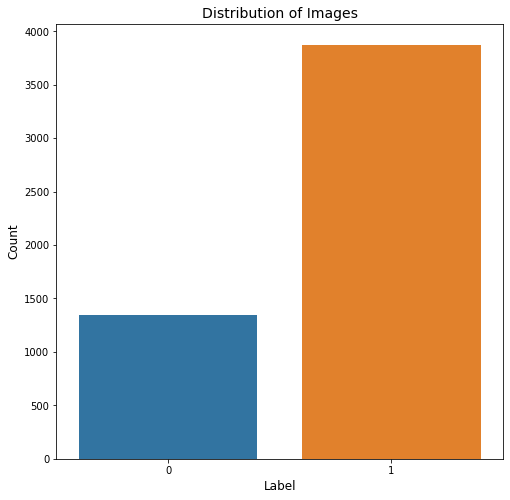

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(df_train['Label'])
ax.set_title('Distribution of Images', fontsize=14)
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.show()

There is a class imbalance and so we need to do augumentation to the dataset to increase it.

In [0]:
def transform_image(img_list):
    img = cv2.resize(img_list, (224, 224))
    #cv2 reads image in BGR format. Let's convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img   

def augment_image(img_list):
    seq = iaa.OneOf([
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            rotate=(-25, 25)
        ),
        iaa.Fliplr(),
        iaa.Multiply((1.2, 1.5))
    ])
    return seq.augment_image(img_list)

def transform_augment_batch(img_path_list, label_list, is_augment=False):
    img_list = []
    for i in range(len(img_path_list)):
        img_list.append(transform_image(cv2.imread(str(img_path_list[i]))))
    n = len(img_list)
    if is_augment:
        for i in range(n):
            img = img_list[i]
            img = augment_image(img)
            img_list.append(img)
        img_list = np.array(img_list)
        label_list = np.append(label_list, label_list)
    return img_list, label_list

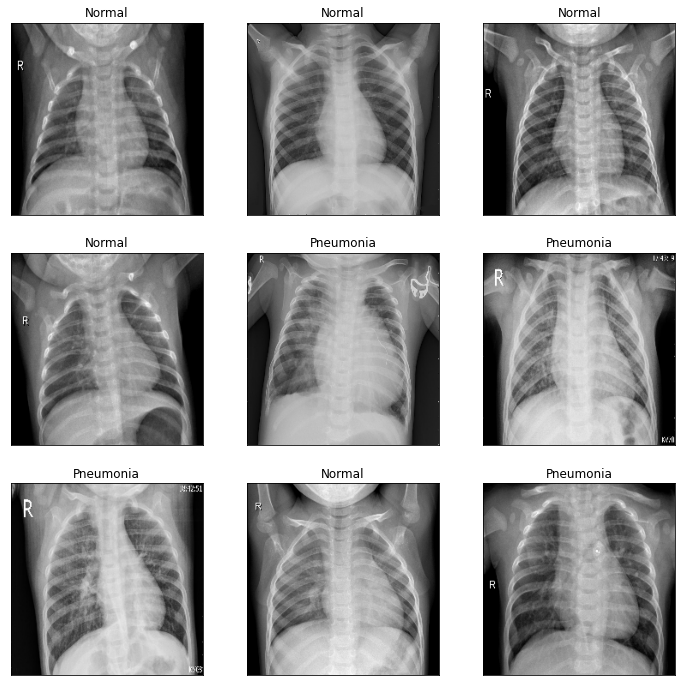

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = transform_image(cv2.imread(str(df_train.iloc[i, 0])))
    plt.imshow(img)
    if df_train.iloc[i, 1] == 0:
        plt.title('Normal')
    else:
        plt.title('Pneumonia')
    plt.xticks([])
    plt.yticks([])
plt.show()

###Visualise Augumented Images

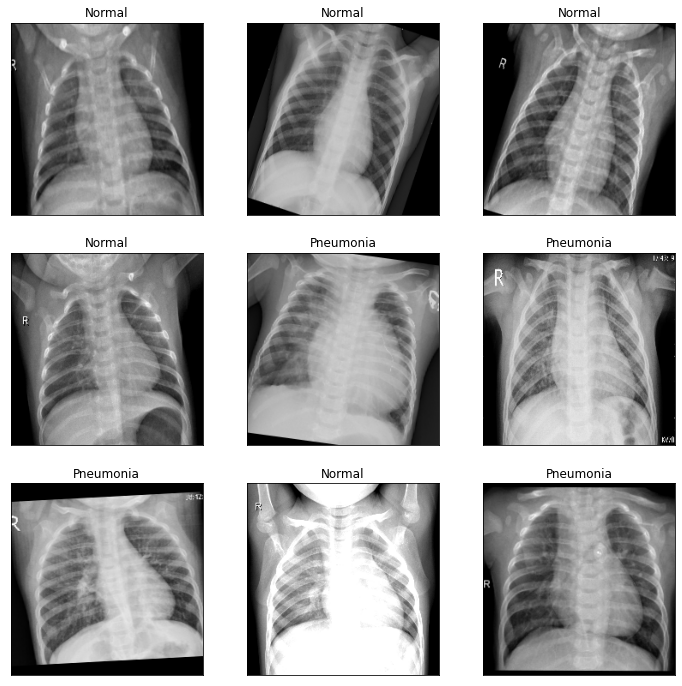

In [12]:
plt.subplots(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = transform_image(cv2.imread(str(df_train.iloc[i, 0])))
    img = augment_image(img)
    plt.imshow(img)
    if df_train.iloc[i, 1] == 0:
        plt.title('Normal')
    else:
        plt.title('Pneumonia')
    plt.xticks([])
    plt.yticks([])
plt.show()

###Let's arrange Validation and Test Data

In [0]:
val_labels = np.array(df_val.iloc[:, 1]).reshape((df_val.shape[0], 1)) #Validation dataset
val_images, _ = transform_augment_batch(df_val.iloc[:, 0], df_val.iloc[:, 1], False)
val_images = np.array(val_images)
val_images = val_images / 255.0

In [14]:
val_images.shape, val_labels.shape

((16, 224, 224, 3), (16, 1))

In [0]:
test_labels = np.array(df_test.iloc[:, 1]).reshape((df_test.shape[0], 1)) #Test dataset
test_images, _ = transform_augment_batch(df_test.iloc[:, 0], df_test.iloc[:, 1], False)
test_images = np.array(test_images)
test_images = test_images / 255.0

In [16]:
test_images.shape, test_labels.shape

((624, 224, 224, 3), (624, 1))

In [0]:
###Deep Learning - TF Hub

In [0]:
# Let's start with the hyperparameters
base_learning_rate = 1e-3
batch_size=32
epochs = 8

In [23]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
# Placeholders
X = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])
Y = tf.placeholder(dtype=tf.float32, shape=[None, 1])
is_train = tf.placeholder_with_default(False, shape=(), name="is_train")

In [0]:
global_step = tf.Variable(0, trainable=False)

In [0]:
#Model from TensorHub
module_spec = hub.load_module_spec("https://tfhub.dev/google/imagenet/resnet_v2_50/classification/1")
module = hub.Module(module_spec)
height, width = hub.get_expected_image_size(module)

In [27]:
# images is a tensor of [batch, 224, 224, 3]
# outputs is a tensor of [batch, 1001]
features = module(X)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [28]:
#Use the features we got from graph and add sigmoid activation 
logits = tf.layers.dense(inputs=features, units=1, activation='sigmoid')

Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


In [0]:
#Learning Rate with exponential decay
learning_rate = tf.train.exponential_decay(base_learning_rate, global_step,1000, 0.96, staircase=True)

In [0]:
#Add loss, optimizer and accuracy to graph
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y))
opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(logits), Y), tf.float32))

In [0]:
#TF session
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

##Training of Model

In [32]:
for epoch in range(epochs):
    s = np.arange(df_train.shape[0])
    np.random.shuffle(s)
    X_dev = np.array(df_train.iloc[s, 0])
    Y_dev = np.array(df_train.iloc[s, 1])
    start_index = 0
    counter = 0
    while start_index < len(X_dev):
        if start_index+batch_size <= len(X_dev):
            end_index = start_index+batch_size
        else:
            end_index = len(X_dev)
        #Select image paths in batches
        x_dev = X_dev[start_index:end_index]
        y_dev = Y_dev[start_index:end_index]
        
        #Transform images and augment
        x_dev, y_dev = transform_augment_batch(x_dev, y_dev, True)
        y_dev = y_dev.reshape((len(y_dev), 1))
        
        #Normalize
        x_dev = x_dev / 255.0
        
        #Train model
        _, cost, acc = sess.run([opt, loss, accuracy], feed_dict={X:x_dev, Y:y_dev, is_train:True})
        start_index = end_index
        counter += 1
    val_acc = sess.run([accuracy], feed_dict={X:val_images, Y:val_labels, is_train:False})
    test_logits = np.zeros((df_test.shape[0], 1))
    start_index = 0
    for i in range(0, df_test.shape[0], 16):
        end_index = start_index + 16
        test_batch_logits = sess.run([logits], feed_dict={X:test_images[start_index:end_index], \
                                                   Y:test_labels[start_index:end_index], is_train:False})
        test_logits[start_index:end_index] = test_batch_logits[0]
        start_index = end_index
    test_acc = np.mean(np.equal(np.round(test_logits), test_labels))
    print('Epoch:{0}, Test_Accuracy:{1}, Validation Accuracy:{2}'.format(epoch+1, test_acc, val_acc))

Epoch:1, Test_Accuracy:0.8701923076923077, Validation Accuracy:[0.9375]
Epoch:2, Test_Accuracy:0.8669871794871795, Validation Accuracy:[0.9375]
Epoch:3, Test_Accuracy:0.8525641025641025, Validation Accuracy:[0.875]
Epoch:4, Test_Accuracy:0.8733974358974359, Validation Accuracy:[0.9375]
Epoch:5, Test_Accuracy:0.844551282051282, Validation Accuracy:[0.875]
Epoch:6, Test_Accuracy:0.8669871794871795, Validation Accuracy:[0.9375]
Epoch:7, Test_Accuracy:0.8397435897435898, Validation Accuracy:[0.875]
Epoch:8, Test_Accuracy:0.8605769230769231, Validation Accuracy:[0.9375]


##Confusion Matrix

<Figure size 432x288 with 0 Axes>

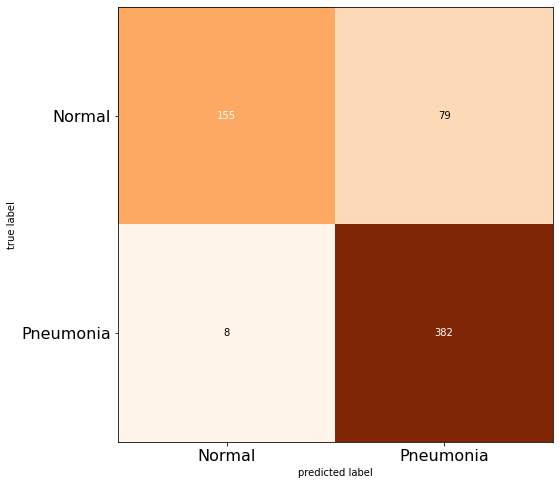

In [33]:
cm  = confusion_matrix(test_labels, np.round(test_logits))
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Oranges)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

##Check Precision, Recall

In [34]:
true_negative, false_positive, false_negative, true_positive  = cm.ravel()
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print('Precison of chest X-ray for pneumonia:{:.2f}'.format(precision))
print('Recall of chest X-ray for pneumonia:{:.2f}'.format(recall))

Precison of chest X-ray for pneumonia:0.83
Recall of chest X-ray for pneumonia:0.98
